<div align="center">
<img src="logo/logo.gif" alt="pycpt logo" width="100"/><p style="line-height: 1.1;"><br><strong>PyCPT</strong><br>Color Palette Tables from <a href="http://seaviewsensing.com/pub/cpt-city/" target="_blank">cpt-city</a><br>in your Python environment.<br>Made in 2025 by Léonard Seydoux</p><br clear="all"/>
</div>

## What is cpt-city?

CPT is short for Color Palette Table, a file format popularized by the [Generic Mapping Tools](https://www.generic-mapping-tools.org/) (GMT) for defining colormaps as piecewise-constant color bands between numeric boundaries.

The [cpt-city](http://seaviewsensing.com/pub/cpt-city/) website maintained by J. J. Green is a community-curated archive of color palettes collected from many projects (e.g., GMT, cmocean, Matplotlib, and more). Palettes are organized in family folders and typically include metadata files like `DESC.xml` and `COPYING.xml` that describe provenance and licensing.

This package is shipped with a `cpt-city/` directory that contains the entire archive obtained from the website. Be mindful that individual palettes may carry different licenses-refer to the accompanying `COPYING.xml` files. Learn more at on the [cpt-city](http://seaviewsensing.com/pub/cpt-city/) website.

In [3]:
import pycpt

## Reading a CPT file

`pycpt.read` accepts either a short name relative to the bundled cpt-city archive (e.g., `"cmocean/algae"`, `"cl/fs2010"`, or simply `"algae"` when unique), or a file path on disk. The file extension is optional; `.cpt` is added automatically. You can also set the logical palette type with `kind` ("sequential" or "diverging"). In the next cell, we read a palette by short name, preview its discrete bands, and check how many segments it has.


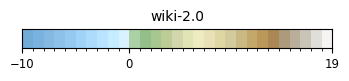

In [4]:
# Load a color palette from the built-in CPT files
palette = pycpt.read("wiki-2.0")

# Show the color palette
palette.plot()

You can load palettes from many families (e.g., `cmocean`, `xkcd`, `gmt`, `wkp`, …). Later in this notebook, we’ll list an entire family with `pycpt.files.get_family(...)` and preview each palette quickly.

Below we switch to another palette and preview its bands.

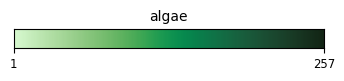

In [5]:
palette = pycpt.read("cmocean/algae")  # also work with "algae"
palette.plot()

## Using the colormap in Matplotlib

There are two common ways to apply a palette:
- Using only `cmap` lets Matplotlib rescale colors to your data range (smooth but may shift intended boundaries).
- Using `cmap` together with `palette.norm` preserves the original CPT boundaries (discrete bands at the authored values).

In the next code cell, the three panels show:
1) Left: `cmap` only (colors are rescaled to the data range).
2) Middle: `cmap + norm` (colors follow original boundaries).
3) Right: Same palette after `palette.scale(vmin, vmax)` and `palette.interpolate(n=...)`, then used with `cmap + norm` and a matching colorbar via `palette.colorbar(...)`.

Tip: For diverging data centered at a value, read with `kind="diverging"` and pass the center to `palette.scale(vmin, vmax, at=center)` so left/right segments preserve their balance.

In [6]:
import numpy as np


def dummy_topography(n=200):
    """Dummy topography data for testing purposes."""
    x = y = np.linspace(-1, 1, n)
    x, y = np.meshgrid(x, y)
    z = 4000 * (x + np.sin(y) + 0.5) + 1000
    return x, y, z

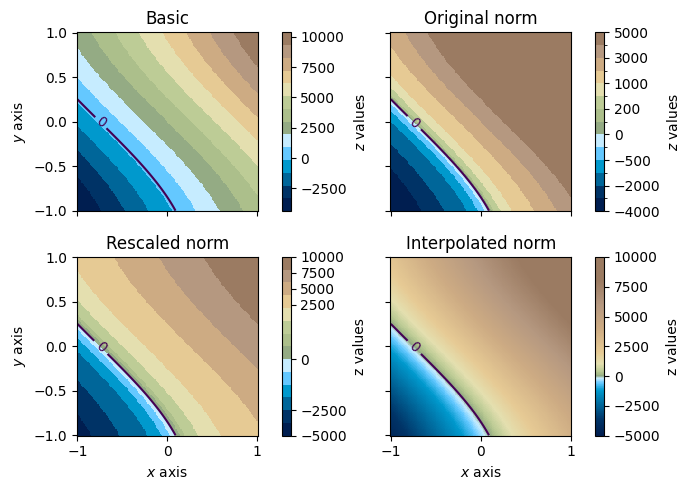

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("matplotlibrc")

# Create data
x, y, z = dummy_topography()
sea_level = 0

# Get colormap and norm from palette
palette = pycpt.read("colombia", kind="diverging")

# Create figure
fig, ax = plt.subplots(
    figsize=(7, 5), ncols=2, nrows=2, sharex=True, sharey=True
)
ax = ax.flatten()

# Without norm
img = ax[0].pcolormesh(x, y, z, cmap=palette.cmap)
ax[0].clabel(ax[0].contour(x, y, z, levels=[sea_level]), [sea_level])
fig.colorbar(img, ax=ax[0], label="$z$ values", pad=0.1)
ax[0].set(title="Basic", ylabel="$y$ axis")

# With norm
img = ax[1].pcolormesh(x, y, z, norm=palette.norm, cmap=palette.cmap)
fig.colorbar(img, ax=ax[1], label="$z$ values", pad=0.1, norm=palette.norm)
ax[1].clabel(ax[1].contour(x, y, z, levels=[sea_level]), [sea_level])
ax[1].set(title="Original norm")

# With norm
palette.scale(-5000, 10000)
img = ax[2].pcolormesh(x, y, z, norm=palette.norm, cmap=palette.cmap)
palette.colorbar(ax=ax[2], label="z values", pad=0.1)
ax[2].clabel(ax[2].contour(x, y, z, levels=[sea_level]), [sea_level])
ax[2].set(title="Rescaled norm", xlabel="$x$ axis", ylabel="$y$ axis")

# Interpolated norm
palette.interpolate(257)
img = ax[3].pcolormesh(x, y, z, norm=palette.norm, cmap=palette.cmap)
palette.colorbar(ax=ax[3], label="z values", pad=0.1)
ax[3].clabel(ax[3].contour(x, y, z, levels=[sea_level]), [sea_level])
ax[3].set(title="Interpolated norm", xlabel="$x$ axis")

# Save figure
fig.tight_layout()

## Listing and previewing a palette family

`pycpt.files.get_family(name)` returns all CPT files under a given family. This is handy to browse a collection and quickly preview each palette’s discrete bands.

Below, we grid a few palettes from the `wkp` family and call `palette.plot` on each. Unused axes are hidden for clarity.

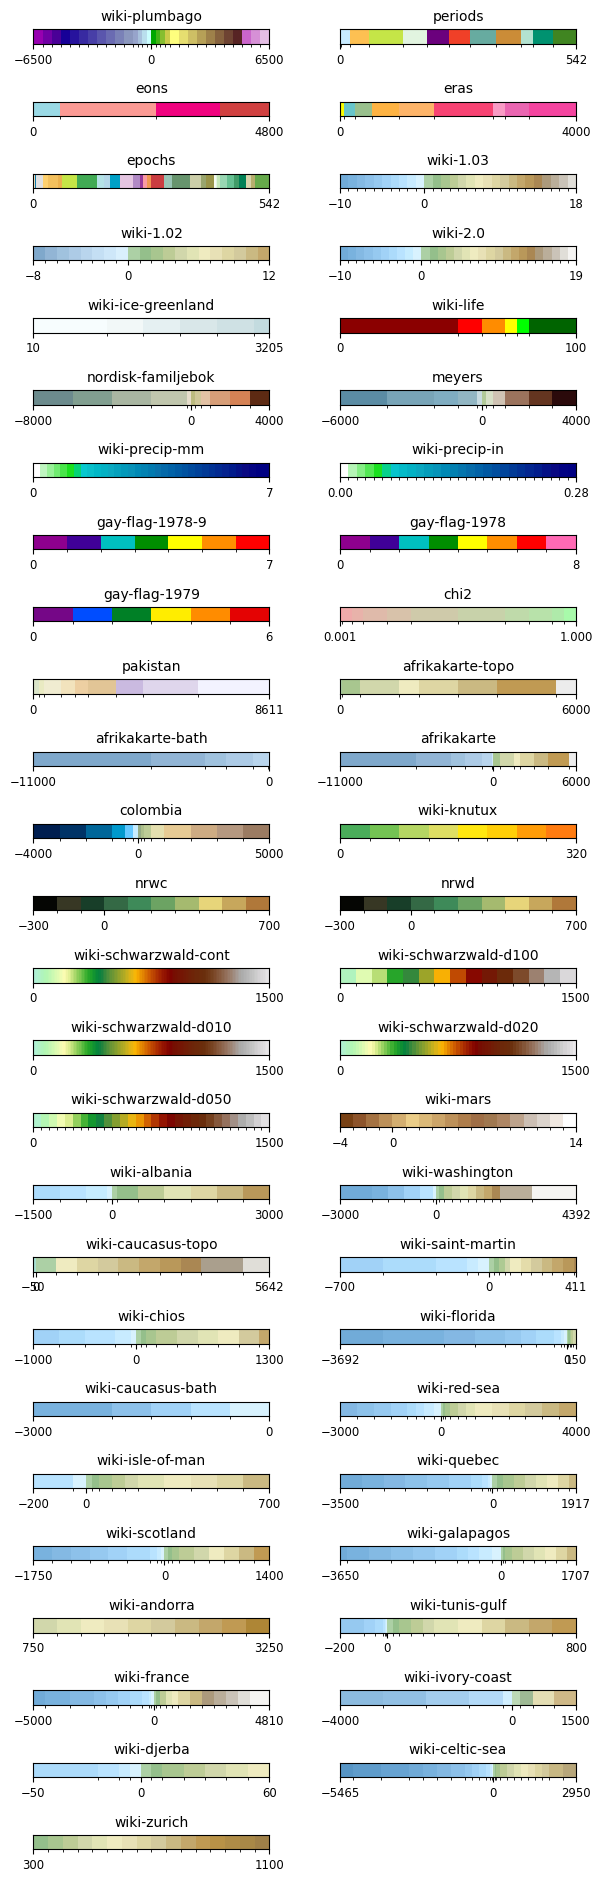

In [10]:
files = pycpt.get_family("wkp")

n_cols = 2
n_rows = int(np.ceil(len(files) / n_cols))
fig, ax = plt.subplots(
    figsize=(7, n_rows / 1.1),
    ncols=n_cols,
    nrows=n_rows,
    gridspec_kw={"wspace": 0.3, "hspace": 4},
)
ax = ax.ravel()
for i, filepath in enumerate(files):
    palette = pycpt.read(filepath)
    palette.plot(ax=ax[i])

# Clear unused axes
for j in range(i + 1, len(ax)):
    ax[j].axis("off")

# fig.tight_layout()
# fig.savefig("wkp_palettes.png")